In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator
from scipy import stats
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, adjusted_rand_score
df = pd.read_csv('../dataset/data_5diagnosis.csv')
df['Diagnosis'].value_counts()
# df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 0 if x == 'Healthy' else 1)

Diagnosis
Healthy                           335
Normocytic hypochromic anemia     263
Normocytic normochromic anemia    262
Iron deficiency anemia            180
Thrombocytopenia                   71
Name: count, dtype: int64

## Arbres de décision

In [203]:
def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_markerfacecolor()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)
 

In [204]:
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']
y = df['Diagnosis'].apply(lambda x: ''.join([word[0] for word in x.split()]))
print(y.value_counts())
#y prend les initial de chaque classe
scaler_s = StandardScaler()
pca = PCA(n_components=2)
pcs = pca.fit_transform(pd.DataFrame(scaler_s.fit_transform(X), columns=X.columns))
pcs = pd.DataFrame(pcs,columns=[f"PC{i}" for i in range(1, 3)])

Diagnosis
H      335
Nha    263
Nna    262
Ida    180
T       71
Name: count, dtype: int64


d:\alexa\Github\projet-sy09\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


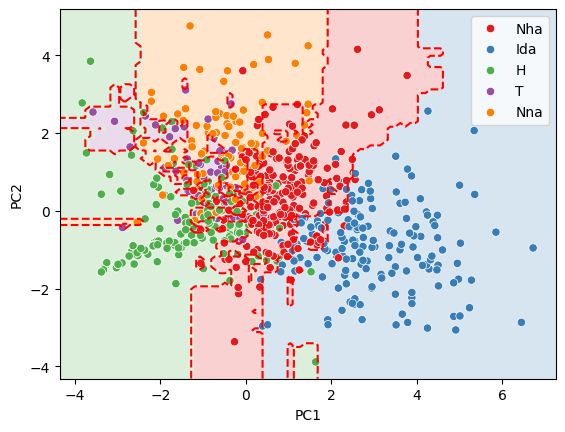

Accuracy: 100.00 %
Adjusted Rand Index: 100.00 %
Classification Report:
              precision    recall  f1-score   support

           H       1.00      1.00      1.00       335
         NHA       1.00      1.00      1.00       180
         NNA       1.00      1.00      1.00       263
         IDA       1.00      1.00      1.00       262
           T       1.00      1.00      1.00        71

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111

Class Distribution (percentage):
H      30.153015
NHA    23.672367
NNA    23.582358
IDA    16.201620
T       6.390639
Name: proportion, dtype: float64
Feature Importances:
  Feature  Importance
0     PC1    0.603005
1     PC2    0.396995
Mean max depth of trees: 16.84
Mean number of leaves: 190.65


d:\alexa\Github\projet-sy09\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


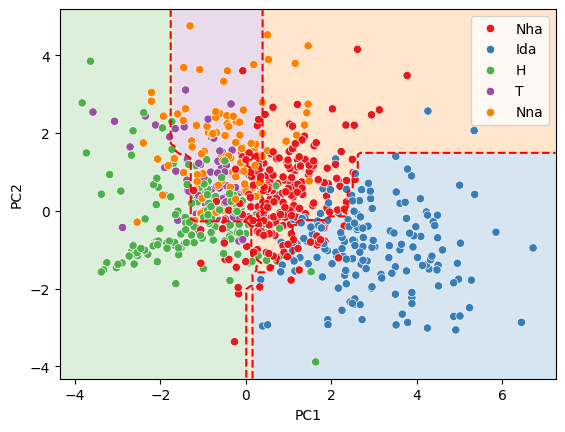

Pruned Model Accuracy: 78.22 %
Pruned Model Adjusted Rand Index: 54.70 %
Pruned Classification Report:
              precision    recall  f1-score   support

           H       0.86      0.82      0.84       335
         NHA       0.90      0.88      0.89       180
         NNA       0.80      0.76      0.78       263
         IDA       0.64      0.90      0.75       262
           T       0.00      0.00      0.00        71

    accuracy                           0.78      1111
   macro avg       0.64      0.67      0.65      1111
weighted avg       0.75      0.78      0.76      1111

Pruned Class Distribution (percentage):
H      30.153015
NHA    23.672367
NNA    23.582358
IDA    16.201620
T       6.390639
Name: proportion, dtype: float64
Pruned Mean max depth of trees: 5.26
Pruned Mean number of leaves: 10.98


d:\alexa\Github\projet-sy09\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\alexa\Github\projet-sy09\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\alexa\Github\projet-sy09\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Fit the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=3)
model.fit(pcs, y)
sns.scatterplot(x="PC1", y="PC2", hue=y, data=pcs, palette="Set1")
add_decision_boundary(model)
plt.show()

# Evaluate the model performance
y_pred = model.predict(pcs)

accuracy = accuracy_score(y, y_pred)
ari = adjusted_rand_score(y, y_pred)

print(f"Accuracy: {accuracy * 100:.2f} %")
print(f"Adjusted Rand Index: {ari * 100:.2f} %")

# Detailed classification report
target_names = [
    "H",
    "NHA",
    "NNA",
    "IDA",
    "T"
]
print("Classification Report:")
print(classification_report(y, y_pred, target_names=target_names))

# Calculate the percentage representation of each class
class_distribution = pd.Series(y).value_counts(normalize=True) * 100
class_distribution.index = target_names

print("Class Distribution (percentage):")
print(class_distribution)

# Retrieve feature importances
feature_importances = model.feature_importances_

features = ["WBC", "RBC", "HGB", "MCV", "MCH", "MCHC", "PLT"]
if len(features) != len(feature_importances):
    print("Warning: Number of features does not match the number of importances. Adjusting the feature list.")
    features = [f"PC{i+1}" for i in range(len(feature_importances))]

importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print("Feature Importances:")
print(importance_df)

# Retrieve additional model parameters
max_depth = [tree.tree_.max_depth for tree in model.estimators_]
mean_max_depth = sum(max_depth) / len(max_depth)

n_leaves = [tree.tree_.n_leaves for tree in model.estimators_]
mean_n_leaves = sum(n_leaves) / len(n_leaves)

print(f"Mean max depth of trees: {mean_max_depth:.2f}")
print(f"Mean number of leaves: {mean_n_leaves:.2f}")

# If using ccp_alpha for pruning (example value)
model_pruned = RandomForestClassifier(n_estimators=100, random_state=3, ccp_alpha=0.01)
model_pruned.fit(pcs, y)
sns.scatterplot(x="PC1", y="PC2", hue=y, data=pcs, palette="Set1")
add_decision_boundary(model_pruned)
plt.show()

# Evaluate pruned model performance
y_pred_pruned = model_pruned.predict(pcs)
accuracy_pruned = accuracy_score(y, y_pred_pruned)
ari_pruned = adjusted_rand_score(y, y_pred_pruned)

print(f"Pruned Model Accuracy: {accuracy_pruned * 100:.2f} %")
print(f"Pruned Model Adjusted Rand Index: {ari_pruned * 100:.2f} %")

# Detailed classification report for pruned model
print("Pruned Classification Report:")
print(classification_report(y, y_pred_pruned, target_names=target_names))

# Calculate the percentage representation of each class for pruned model
print("Pruned Class Distribution (percentage):")
print(class_distribution)

# Retrieve pruned model parameters
max_depth_pruned = [tree.tree_.max_depth for tree in model_pruned.estimators_]
mean_max_depth_pruned = sum(max_depth_pruned) / len(max_depth_pruned)

n_leaves_pruned = [tree.tree_.n_leaves for tree in model_pruned.estimators_]
mean_n_leaves_pruned = sum(n_leaves_pruned) / len(n_leaves_pruned)

print(f"Pruned Mean max depth of trees: {mean_max_depth_pruned:.2f}")
print(f"Pruned Mean number of leaves: {mean_n_leaves_pruned:.2f}")